# Outages and Storm EDA
Creator: [REDACTED]
This notebook is an EDA to understand the provided information and think about additional datasources to solve the problem.
The most relevant paper on OUTAGES can be seen [here](https://www.researchgate.net/publication/378737750_A_dataset_of_recorded_electricity_outages_by_United_States_county_2014-2022).

## Imports 

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

import utils_dhm as ut

## Configuration

In [2]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 200)

## Constants

In [3]:
# Eagle-I related data paths
YEAR = '2015'
EAGLEI_DATA_PATH = '../data/raw/dynamic-rhythms-train-data/data/eaglei_data/'
MCC_PATH = f'{EAGLEI_DATA_PATH}MCC.csv'
DQI_PATH = f'{EAGLEI_DATA_PATH}DQI.csv'

# NOAA Storm Events related data paths
NOAA_DATA_PATH = '../data/raw/dynamic-rhythms-train-data/data/NOAA_StormEvents/'
STORM_EVENTS_PATH = f'{NOAA_DATA_PATH}StormEvents_2014_2024.csv'
STORM_DETAILS_PATH = f'{NOAA_DATA_PATH}StormEvents_details-ftp_v1.0_d2015_c20240716.csv'

# Relevance is determined by the amount of customers being affected, in this case we define
CUSTOMERS_OUT_NB = 1e4

## Functions

In [4]:
def get_required_outages_dfs(eaglei_data_path=None, *years ):
    eaglei_data_paths = os.listdir(eaglei_data_path)
    paths = []
    for year in years:
        paths += [f'{eaglei_data_path}{file}' for file in eaglei_data_paths if str(year) in file]
    dfs = []
    for file in paths:
        print(f"Reading file: {file}.")
        dfs.append(pd.read_csv(file))
    print("Done.")
    if len(paths) > 1: 
        print("Merging information.")
        outages_df = pd.concat(dfs)
    else:
        outages_df = dfs[0]
    print('Data is ready.')

    return outages_df
    

def get_outages_index(outages_county):
    outages_county = outages_county.sort_values("run_start_time")
    # Then we keep only the relevant outage (affecting a high amount of customers)
    outages_county = outages_county[outages_county.customers_out >= CUSTOMERS_OUT_NB]
    # We can define a sepparation of continuity to "divide" timelapses, in other words, sepparate outages events. 
    sepparation_hours = 18 # number of hours to define a sepparation between outages
    # We calculate the difference in seconds of each outage
    MIN_OUTAGE_SECONDS = 60 * 15 # Represents 15 minutes, in seconds
    NB_15_MIN_IN_HOUR = 4
    outages_county['second_difference'] = outages_county.run_start_time.diff().dt.total_seconds()
    # Each time we find an interval mark greater than the sepparation time (deffined in sepparation_hours), we identify it as true (1), or false (0).
    sepparation_hours_seconds = MIN_OUTAGE_SECONDS * NB_15_MIN_IN_HOUR *(sepparation_hours)
    outages_county['interval_mark'] = (outages_county.second_difference.fillna(MIN_OUTAGE_SECONDS) > sepparation_hours_seconds).astype(int)
    # then we do the cumulativesum to "generate an index" of same representation. 
    outages_county['outage_index'] = outages_county['interval_mark'].cumsum() 
    return outages_county

## Read data

### Power Outages:
We have a range of datasets, going from eaglei_outages_2014 to eaglei_outages_2023.
[EAGLE-I](https://eagle-i.doe.gov) is an interactive geographic information system (GIS) that allows users to view and map the nation's energy infrastructure and obtain near real-time informational updates concerning the electric, petroleum and natural gas sectors within one visualization platform.
It contains information on the total number of customers out of power for every 15 minutes that starts at `run_start_time`

The EAGLE-I outage data represents 80% to 90% of utility customers nationally, with higher coverage rates later in our dataset. The coverage extent increased as additional parsing capabilities were developed and as data sharing agreements with other response agencies and utilities were formalized. If an electric utility is not included in EAGLE-I monitoring, that utility is omitted from EAGLE-I data calculations. If a county has no covered electric customers because all utilities (one or more) associated with that county are not monitored by EAGLE-I, then that county is omitted from EAGLE-I reports and data calculations. In 2014, 1,072 counties had no outage data collected, while in 2022, only 182 counties had no outage data collected, out of 3,222 total counties and county equivalents.
This is according to [[1]](https://www.nature.com/articles/s41597-024-03095-5)

In [5]:
dqi = pd.read_csv(DQI_PATH)
mcc = pd.read_csv(MCC_PATH)
outages = get_required_outages_dfs(eaglei_data_path=EAGLEI_DATA_PATH, 2014, 2015, 2016)

ERROR! Session/line number was not unique in database. History logging moved to new session 2
Reading file: ../data/raw/dynamic-rhythms-train-data/data/eaglei_data/eaglei_outages_2014.csv.
Reading file: ../data/raw/dynamic-rhythms-train-data/data/eaglei_data/eaglei_outages_2015.csv.
Reading file: ../data/raw/dynamic-rhythms-train-data/data/eaglei_data/eaglei_outages_2016.csv.
Done.
Merging information.
Data is ready.


In [6]:
outages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934641 entries, 0 to 13306023
Data columns (total 5 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   fips_code       int64 
 1   county          object
 2   state           object
 3   customers_out   int64 
 4   run_start_time  object
dtypes: int64(2), object(3)
memory usage: 1.2+ GB


### Storm Data
Storm data is provided by the National Oceanic and Atmospheric Administration (NOAA). There is a recompilation of storm event details from 2014 to 2024, with one .csv file for each year. These files are directly downloaded from NOAA's storm events public database.

In [181]:
storm_events = pd.read_csv(STORM_EVENTS_PATH)
storm_details = pd.read_csv(STORM_DETAILS_PATH)

## Understand Data

### Outages

#### Outages Dataset

`fips_code`: _Federal Information Processing System (FIPS) Codes for States and Counties
FIPS codes are numbers which uniquely identify geographic areas.  The number of 
digits in FIPS codes vary depending on the level of geography.  State-level FIPS
codes have two digits, county-level FIPS codes have five digits of which the 
first two are the FIPS code of the state to which the county belongs._

`customers_out`: Amount of affected customers (estimate) at a 15-minute interval from the `run_start_time` moment. 

`state` and `county`: Deffinition of where the outage ocurred. 

`run_start_time`: Datetime of information on the customers_out measurement.

In [8]:
outages

,fips_code,county,state,customers_out,run_start_time
0,1037,Coosa,Alabama,12,2014-11-01 04:00:00
1,1051,Elmore,Alabama,7,2014-11-01 04:00:00
2,1109,Pike,Alabama,1,2014-11-01 04:00:00
3,1121,Talladega,Alabama,31,2014-11-01 04:00:00
4,4017,Navajo,Arizona,1,2014-11-01 04:00:00
...,...,...,...,...,...
13306019,54061,Monongalia,West Virginia,472,2016-12-31 00:00:00
13306020,54069,Ohio,West Virginia,37,2016-12-31 00:00:00
13306021,54075,Pocahontas,West Virginia,200,2016-12-31 00:00:00
13306022,54099,Wayne,West Virginia,2,2016-12-31 00:00:00


In [9]:
# Small data process
outages.run_start_time = pd.to_datetime(outages.run_start_time) # Transform into datetime to manipulate dates
outages = outages[outages.customers_out.notna()] # Filter nan values from customers_out
outages["state_id"] = outages.state.map(ut.STATE_ABBREVIATIONS) # Use the state abbreviations to get an ID
outages["fips_code_id"] = outages.fips_code.astype(str).str.zfill(5)
outages["sub_general_id"] = (outages.fips_code_id + '_' + outages.state_id)

In [10]:
#outages["general_id"] = (
#    outages.fips_code_id + '_' + 
#    outages.state_id + '_' + 
#    outages.run_start_time.dt.date.astype(str)
#)

In [11]:
#outages.sample(5)

In [12]:
# 15-Minute intervals
#general_id_aggregation = outages.general_id.value_counts()

In [13]:
#plt.figure(figsize=(10,15))
#general_id_aggregation.rename("Time intervals").value_counts().sort_index().plot(kind='barh')
#plt.title("Count of the General_ids with different information dates")
# 96 is the maximum since it represents 24 hours * 4  15-minute intervals each hour
# 1 is the minimum since it represents only one register was captured. 

In [14]:
# 96 Registers over time (representing a day from the beginning 00:00 to the end 24:00)
#outages[
#    outages.general_id == general_id_aggregation[general_id_aggregation==96
#].sample(1).index.values[0]].plot(x='run_start_time', y='customers_out', marker='o')

In [15]:
# 50 Registers over time (representing part of a day from the beginning (not necesarrily 00:00) to the end)
#outages[
#    outages.general_id == general_id_aggregation[general_id_aggregation==50
#].sample(1).index.values[0]].plot(x='run_start_time', y='customers_out', marker='o')

In [16]:
# Sometimes there is no continuous outage information within a day. 
#outages[
#    outages.general_id == general_id_aggregation[general_id_aggregation==10
#].sample(1).index.values[0]].plot(x='run_start_time', y='customers_out', marker='o')

Small conclusion: Days are non-important we need to tackle the problem mesuring the span of the outage.

<Axes: xlabel='run_start_time', ylabel='customers_out'>

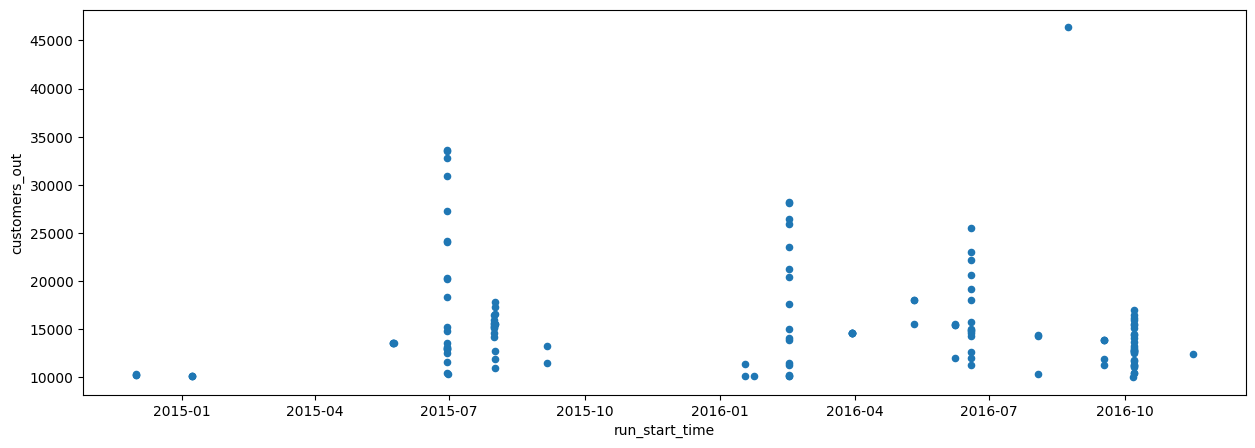

In [17]:
# In this initial test we grab a county
outage_test = outages[outages.sub_general_id=='12086_FL'].sort_values("run_start_time")
# Then we keep only the relevant outage (affecting a high amount of customers)
outage_test = outage_test[outage_test.customers_out >= CUSTOMERS_OUT_NB]

fig, ax = plt.subplots(figsize=(15,5))
outage_test.plot(x='run_start_time', y='customers_out', marker='o', ax=ax, kind='scatter')

<Axes: xlabel='run_start_time', ylabel='customers_out'>

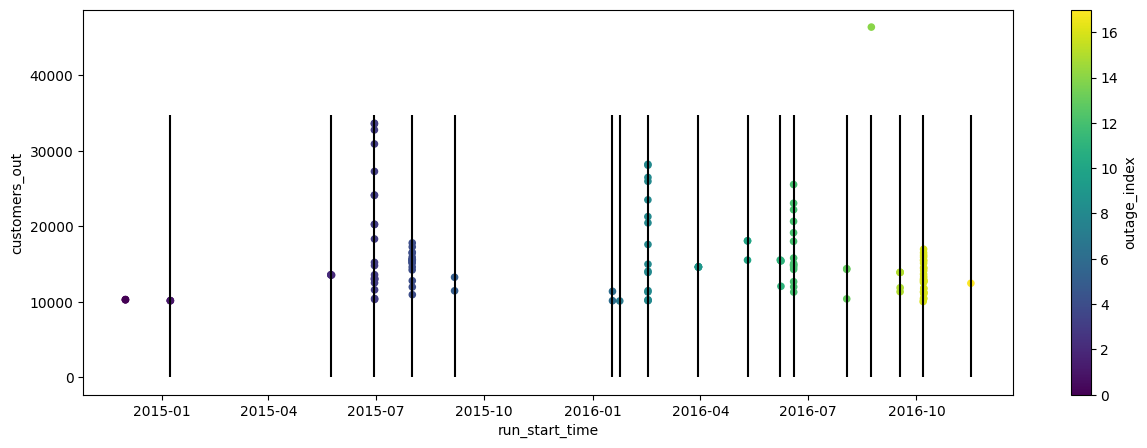

In [18]:
# We can define a sepparation of continuity to "divide" timelapses, in other words, sepparate outages events. 
sepparation_hours = 18 # number of hours to define a sepparation between outages
# We calculate the difference in seconds of each outage
MIN_OUTAGE_SECONDS = 60 * 15 # Represents 15 minutes, in seconds
NB_15_MIN_IN_HOUR = 4
outage_test['second_difference'] = outage_test.run_start_time.diff().dt.total_seconds()
# Each time we find an interval mark greater than the sepparation time (deffined in sepparation_hours), we identify it as true (1), or false (0).
sepparation_hours_seconds = MIN_OUTAGE_SECONDS * NB_15_MIN_IN_HOUR *(sepparation_hours)
outage_test['interval_mark'] = (outage_test.second_difference.fillna(MIN_OUTAGE_SECONDS) > sepparation_hours_seconds).astype(int)
# then we do the cumulativesum to "generate an index" of same representation. 
outage_test['outage_index'] = outage_test['interval_mark'].cumsum() 

# We can plot the "different outages", divided with the interval marks
fig, ax = plt.subplots(figsize=(15,5))
intervals = outage_test[outage_test['interval_mark']==1]
plt.vlines(intervals.run_start_time, 0, outage_test.customers_out.max()*0.75, color='k')
outage_test.plot(x='run_start_time', y='customers_out', c='outage_index', marker='o', ax=ax, kind='scatter',cmap='viridis')

In [19]:
pd.set_option('display.max_rows', 200)
outage_test

,fips_code,county,state,customers_out,run_start_time,state_id,fips_code_id,sub_general_id,second_difference,interval_mark,outage_index
927068,12086,Miami-Dade,Florida,10247,2014-12-01 00:00:00,FL,12086,12086_FL,NaN,0,0
927332,12086,Miami-Dade,Florida,10251,2014-12-01 00:15:00,FL,12086,12086_FL,900.0,0,0
927582,12086,Miami-Dade,Florida,10282,2014-12-01 00:30:00,FL,12086,12086_FL,900.0,0,0
174867,12086,Miami-Dade,Florida,10133,2015-01-08 01:15:00,FL,12086,12086_FL,3285900.0,1,1
175301,12086,Miami-Dade,Florida,10125,2015-01-08 01:30:00,FL,12086,12086_FL,900.0,0,1
175731,12086,Miami-Dade,Florida,10125,2015-01-08 01:45:00,FL,12086,12086_FL,900.0,0,1
4071728,12086,Miami-Dade,Florida,13559,2015-05-24 00:15:00,FL,12086,12086_FL,11745000.0,1,2
4074111,12086,Miami-Dade,Florida,13543,2015-05-24 01:45:00,FL,12086,12086_FL,5400.0,0,2
4074481,12086,Miami-Dade,Florida,13533,2015-05-24 02:00:00,FL,12086,12086_FL,900.0,0,2
4093326,12086,Miami-Dade,Florida,13520,2015-05-24 16:45:00,FL,12086,12086_FL,53100.0,0,2


<Axes: ylabel='outage_index'>

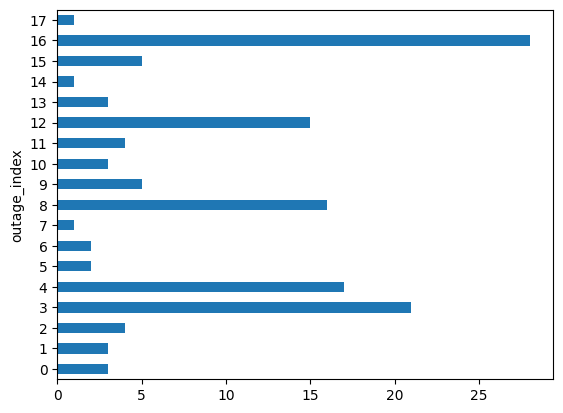

In [20]:
outage_test.outage_index.value_counts().sort_index().plot(kind="barh")

In [21]:
outage_test_summary = outage_test.groupby(
    'outage_index'
).agg(
    fips_code=('fips_code', 'first'),
    fips_code_id=('fips_code_id', 'first'),
    county=('county', 'first'),
    state=('state', 'first'),
    state_id=('state_id', 'first'),
    total_relevant_registers=('customers_out', 'count'),
    total_customers_out=('customers_out', 'sum'),
    run_start_time_min=('run_start_time', 'min'),
    run_start_time_max=('run_start_time', 'max'),
).reset_index()

In [22]:
outage_test_summary['general_id'] = outage_test_summary.fips_code_id + '__' + outage_test_summary.outage_index.astype(str).str.zfill(4)
outage_test_summary['outage_duration'] = (
    outage_test_summary.run_start_time_max - outage_test_summary.run_start_time_min
).dt.total_seconds()

Text(0, 0.5, 'count')

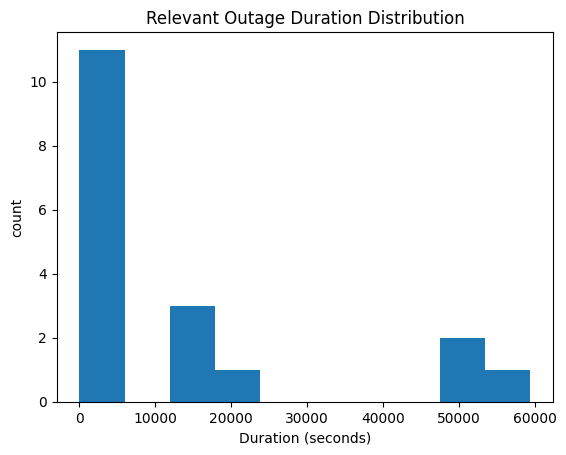

In [23]:
plt.title("Relevant Outage Duration Distribution")
plt.hist(outage_test_summary.outage_duration)
plt.xlabel('Duration (seconds)')
plt.ylabel('count')

In [24]:
# Do the same for all counties
outages_index = outages.groupby('sub_general_id').apply(get_outages_index)
outages_index['outage_index_id'] = outages_index.fips_code_id + '__' + outages_index.outage_index.astype(str).str.zfill(4)
outages_index_resumed = outages_index.groupby(
    'outage_index_id'
).agg(
    fips_code=('fips_code', 'first'),
    fips_code_id=('fips_code_id', 'first'),
    county=('county', 'first'),
    state=('state', 'first'),
    state_id=('state_id', 'first'),
    total_relevant_registers=('customers_out', 'count'),
    total_customers_out=('customers_out', 'sum'),
    run_start_time_min=('run_start_time', 'min'),
    run_start_time_max=('run_start_time', 'max'),
).reset_index()

# We are adding the time interval of 15 miuntes to the last element. 
outages_index_resumed['run_start_time_max'] = outages_index_resumed['run_start_time_max'] + pd.to_timedelta(900, unit='s')

outages_index_resumed['outage_duration'] = (
    outages_index_resumed.run_start_time_max - outages_index_resumed.run_start_time_min
).dt.total_seconds()/3600/24 # We get the days of time difference

outages_index_resumed['outage_customers_over_duration'] = outages_index_resumed['total_customers_out']/outages_index_resumed['outage_duration']
outages_index_resumed['state'] = outages_index_resumed['state'].str.lower()

/tmp/ipykernel_28197/3235826873.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outages_index = outages.groupby('sub_general_id').apply(get_outages_index)


In [25]:
outages_index_resumed.sort_values('outage_duration')

,outage_index_id,fips_code,fips_code_id,county,state,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration
591,24017__0000,24017,24017,Charles,maryland,MD,1,10015,2015-04-07 17:30:00,2015-04-07 17:45:00,0.010417,9.614400e+05
590,24015__0002,24015,24015,Cecil,maryland,MD,1,11139,2016-10-24 19:45:00,2016-10-24 20:00:00,0.010417,1.069344e+06
588,24015__0000,24015,24015,Cecil,maryland,MD,1,12931,2015-06-01 11:00:00,2015-06-01 11:15:00,0.010417,1.241376e+06
585,24003__0001,24003,24003,Anne Arundel,maryland,MD,1,10225,2016-08-16 02:15:00,2016-08-16 02:30:00,0.010417,9.816000e+05
1394,53033__0017,53033,53033,King,washington,WA,1,20224,2016-12-15 22:15:00,2016-12-15 22:30:00,0.010417,1.941504e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
413,13051__0004,13051,13051,Chatham,georgia,GA,516,35524853,2016-10-07 22:15:00,2016-10-13 12:00:00,5.572917,6.374553e+06
405,12127__0000,12127,12127,Volusia,florida,FL,519,48574016,2016-10-07 05:45:00,2016-10-12 20:15:00,5.604167,8.667482e+06
321,12031__0010,12031,12031,Duval,florida,FL,560,48741221,2016-10-07 15:15:00,2016-10-13 16:30:00,6.052083,8.053627e+06
973,37155__0000,37155,37155,Robeson,north carolina,NC,559,14554717,2016-10-08 17:15:00,2016-10-14 18:45:00,6.062500,2.400778e+06


Text(0.5, 0, '(Duration) [days]')

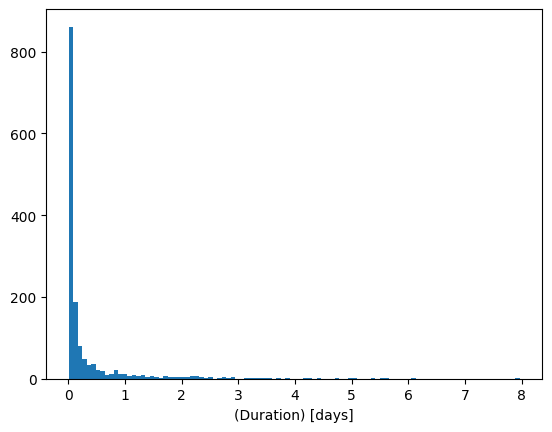

In [26]:
plt.hist(outages_index_resumed.outage_duration, bins=100,)
plt.xlabel('(Duration) [days]')

In [27]:
outages_index_resumed[outages_index_resumed.outage_duration==outages_index_resumed.outage_duration.max()]


,outage_index_id,fips_code,fips_code_id,county,state,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration
1418,53063__0002,53063,53063,Spokane,washington,WA,747,42833797,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06


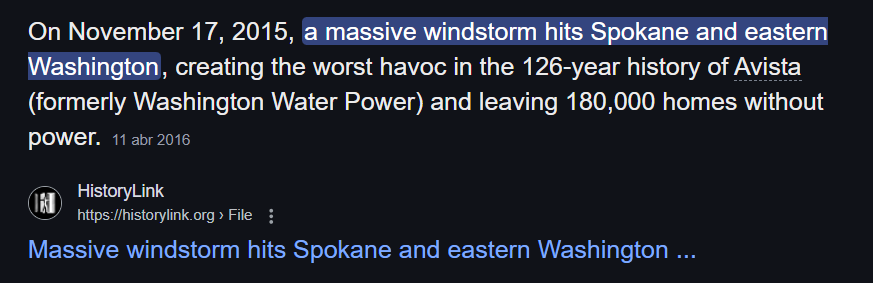

#### DQI

`fema`: Federal Emergency Management Agency (FEMA) mission is helping people before, during and after disasters. Our core values and goals help us achieve it. In this case it is the Federal Emergency Management Agency (FEMA) region.
 
`success_rate`: The Success Rate component of the DQI.

`percent_enabled`: The Percent Enabled component of the DQI.

`spatial_precision`: The Spatial Precision component of the DQI.

`cust_coverage`:The Customer Coverage component of the DQI.

`max_covered`: The maximum number of customers covered in this region/year.

`total_customers`: The estimated total number of customers in this region/year.

`DQI`: the Final data quality index.


In [276]:
#dqi

### Storms

#### Storm Events

In [29]:
#storm_events.columns, len(storm_events.columns)
storm_events.sample(5)

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
441134,202104,23,1624,202104,23,1624,157750,955105,TEXAS,48,2021,April,Hail,C,275,KNOX,OUN,23-APR-21 16:24:00,CST-6,23-APR-21 16:24:00,0,0,0,0,0.00K,0.00K,Trained Spotter,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,N,RHINELAND,3.0,N,RHINELAND,33.57,-99.65,33.57,-99.65,A dryline and an upper trough led to the devel...,NaN,CSV
402426,202010,25,1300,202010,26,1800,152601,919201,COLORADO,8,2020,October,Winter Storm,Z,10,GORE AND ELK MOUNTAINS/CENTRAL MOUNTAIN VALLEYS,GJT,25-OCT-20 13:00:00,MST-7,26-OCT-20 18:00:00,0,0,0,0,0.00K,0.00K,CoCoRaHS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A very strong and dynamic cold front moved thr...,Average snowfall was between 7 to 10 inches ac...,CSV
145399,201612,25,900,201612,25,1500,112394,670228,SOUTH DAKOTA,46,2016,December,Ice Storm,Z,15,DEWEY,ABR,25-DEC-16 09:00:00,CST-6,25-DEC-16 15:00:00,0,0,0,0,223.00K,0.00K,Utility Company,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An intense surface low pressure area moved fro...,NaN,CSV
390744,202004,16,2300,202004,17,800,147882,890516,VIRGINIA,51,2020,April,Frost/Freeze,Z,53,FAIRFAX,LWX,16-APR-20 23:00:00,EST-5,17-APR-20 08:00:00,0,0,0,0,NaN,NaN,Mesonet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canadian high pressure ushered in chilly condi...,NaN,CSV
103635,201506,19,658,201506,19,658,95146,574776,MISSOURI,29,2015,June,Heavy Rain,C,77,GREENE,SGF,19-JUN-15 06:58:00,CST-6,19-JUN-15 06:58:00,0,0,0,0,0.00K,0.00K,NWS Employee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,SW,WILDWOOD ESTATES,3.0,SW,WILDWOOD ESTATES,37.09,-93.29,37.09,-93.29,The remnants of Tropical Storm Bill moved slow...,A 24 hour rainfall total of 5.50 inches was re...,CSV


In [182]:
# Lets consider only County
storm_events = storm_events#[storm_events.CZ_TYPE == 'C']

In [183]:
storm_events.EVENT_TYPE.value_counts()

EVENT_TYPE
Thunderstorm Wind             186450
Hail                           97652
Flash Flood                    43539
Winter Weather                 40154
High Wind                      38746
Drought                        32432
Winter Storm                   31878
Flood                          30209
Marine Thunderstorm Wind       25147
Heavy Snow                     24231
Tornado                        15641
Heat                           15437
Heavy Rain                     15310
Excessive Heat                 13803
Strong Wind                    11356
Extreme Cold/Wind Chill         9511
Dense Fog                       7567
Cold/Wind Chill                 6306
Frost/Freeze                    6100
Blizzard                        5889
High Surf                       4329
Wildfire                        3637
Lightning                       3609
Tropical Storm                  3184
Funnel Cloud                    3071
Ice Storm                       2566
Coastal Flood              

In [184]:
begin_datetime = (
    storm_events['BEGIN_YEARMONTH'].astype(str) + 
    storm_events['BEGIN_DAY'].astype(str).str.zfill(2) + 
    storm_events['BEGIN_TIME'].astype(str).str.zfill(4)
)

end_datetime = (
    storm_events['END_YEARMONTH'].astype(str) + 
    storm_events['END_DAY'].astype(str).str.zfill(2) + 
    storm_events['END_TIME'].astype(str).str.zfill(4)
)

storm_events['BEGIN_DATETIME'] = pd.to_datetime(begin_datetime,format='%Y%m%d%H%M')
storm_events['END_DATETIME'] = pd.to_datetime(end_datetime, format='%Y%m%d%H%M')
storm_events['DURATION_HOURS'] = (
    storm_events['END_DATETIME'] - storm_events['BEGIN_DATETIME']
).dt.total_seconds() / 3600


In [185]:
storm_events.EPISODE_ID.value_counts().head(30)

EPISODE_ID
142499    251
175359    232
180221    229
194441    202
178154    185
184038    182
181487    182
164574    182
150363    178
171798    173
180197    171
133801    167
192058    163
147540    158
95985     156
191762    156
194443    154
135643    153
115177    151
193998    148
112433    146
164526    146
88093     144
186965    144
147189    140
137355    139
85456     138
189932    135
147190    133
92934     132
Name: count, dtype: int64

`EPISODE_ID`: ID assigned by NWS to denote the storm episode; links the event details file with the
information within location file

`EVENT_ID`: Primary database key field.ID assigned by NWS to note a single, small part that goes into a specific storm episode; links the storm episode between the three files downloaded from SPC’s website. 

`STATE`: The state name where the event occurred

`STATE_FIPS`:A unique number (State Federal Information Processing Standard) is assigned to the county by the National Institute for Standards and Technology (NIST)

`CZ_TYPE`: Indicates whether the event happened in a (C) county/parish, (Z) zone or (M) marine.

`CZ_FIPS`: The county FIPS number is a unique number assigned to the county by the National Institute for Standards and Technology (NIST) or NWS Forecast Zone Number.

`CZ_NAME`:County/Parish, Zone or Marine Name assigned to the county FIPS number or NWS Forecast Zone.

`WFO`: National Weather Service Forecast Office’s area of responsibility (County Warning Area) in which the event occurred

`BEGIN_DATE_TIME`: Date and time that storm event began (MM/DD/YYYY 24 hour time AM/PM).

`CZ_TIMEZONE`:(Time Zone for the County/Parish, Zone or Marine Name) Eastern Standard Time (EST), Central Standard Time (CST), Mountain Standard Time (MST), etc.

`END_DATE_TIME`: Date and time that storm event ended (MM/DD/YYYY 24 hour time AM/PM).

For more information visit this [link](https://adata.site.wesleyan.edu/files/2017/08/Storm_Event_Data_Codebook.pdf).


In [186]:
#storm_events_test

In [187]:
drop_cols = [
    'BEGIN_YEARMONTH',
    'BEGIN_DAY',
    'BEGIN_TIME',
    'END_YEARMONTH',
    'END_DAY',
    'END_TIME',
    'MONTH_NAME',
    'YEAR',
    'WFO',
    'BEGIN_DATE_TIME',
    'END_DATE_TIME',
    'INJURIES_DIRECT',
    'INJURIES_INDIRECT',
    'DEATHS_DIRECT',
    'DEATHS_INDIRECT',
    'DAMAGE_PROPERTY',
    'DAMAGE_CROPS',
    'SOURCE',
    'MAGNITUDE',
    'MAGNITUDE_TYPE',
    'FLOOD_CAUSE',
    'CATEGORY',
    'TOR_F_SCALE',
    'TOR_LENGTH',
    'TOR_WIDTH',
    'TOR_OTHER_WFO',
    'TOR_OTHER_CZ_STATE',
    'TOR_OTHER_CZ_FIPS',
    'TOR_OTHER_CZ_NAME',
    'DATA_SOURCE'
]


In [188]:
# Lets grab a sample
storm_events_test = storm_events[storm_events.EPISODE_ID==109423]
storm_events_test.drop(columns=drop_cols, inplace=True)
# Only consider county
storm_events_test = storm_events_test.sort_values('BEGIN_DATETIME')#[storm_events_test.CZ_TYPE == 'C'].sort_values('BEGIN_DATETIME')
storm_events_test['sequence'] = range(storm_events_test.shape[0])

/tmp/ipykernel_28197/3475847700.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storm_events_test.drop(columns=drop_cols, inplace=True)


In [277]:
#storm_events_test

Text(0.5, 0, 'Time')

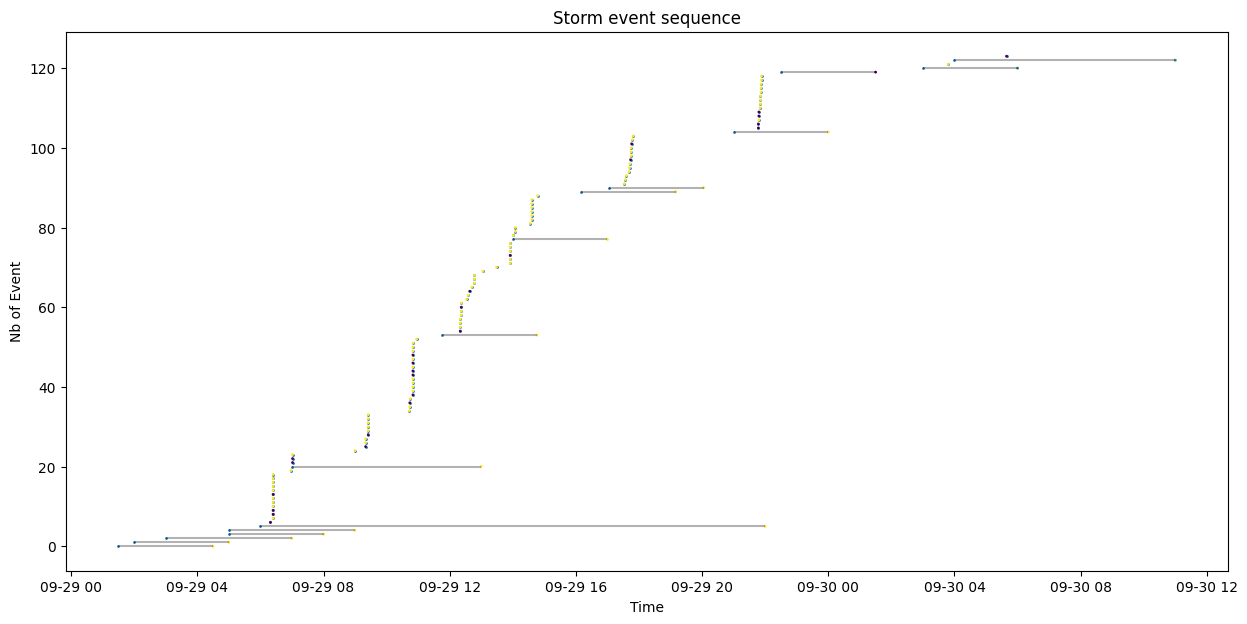

In [190]:
plt.figure(figsize=(15,7))
plt.scatter(storm_events_test.BEGIN_DATETIME, storm_events_test.sequence, s=1)
plt.scatter(storm_events_test.END_DATETIME, storm_events_test.sequence, s=1, c=storm_events_test.CZ_FIPS)
plt.hlines(storm_events_test.sequence, storm_events_test.BEGIN_DATETIME, storm_events_test.END_DATETIME, color='k', alpha=0.3)
plt.title('Storm event sequence')
plt.ylabel('Nb of Event')
plt.xlabel('Time')

In [193]:
storm_episodes = storm_events.groupby("EPISODE_ID").agg(
    nb_events=('EVENT_ID', 'count'),
    affected_states=('STATE', 'unique'),
    affected_states_ids=('STATE_FIPS', 'unique'),
    distinct_events=('EVENT_TYPE', 'unique'),
    touched_cz_fips=('CZ_FIPS', 'unique'),
    touched_cz_names=('CZ_NAME', 'unique'),
    timezone=('CZ_TIMEZONE', 'unique'),
    episode_description=('EPISODE_NARRATIVE','first'),
    begin_datetime=('BEGIN_DATETIME', 'min'),
    end_datetime=('END_DATETIME', 'max'),
).reset_index()

In [194]:
storm_episodes['duration'] = ((storm_episodes.end_datetime - storm_episodes.begin_datetime).dt.total_seconds()/3600).replace(0, 0.01)
storm_episodes['state'] = storm_episodes.affected_states.apply(lambda x: x[0]).str.lower()

In [195]:
#storm_episodes = storm_episodes[storm_episodes.duration!=0]

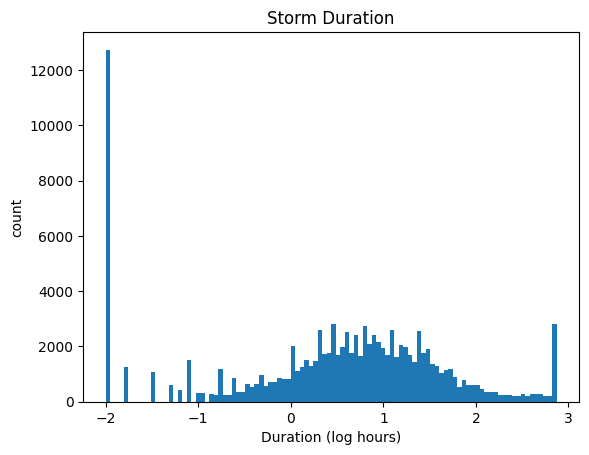

In [196]:
plt.title('Storm Duration')
plt.hist(np.log10(storm_episodes.duration), bins=100)
plt.xlabel('Duration (log hours)')
plt.ylabel('count')
plt.show()

In [197]:
storm_episodes.sample(5)

,EPISODE_ID,nb_events,affected_states,affected_states_ids,distinct_events,touched_cz_fips,touched_cz_names,timezone,episode_description,begin_datetime,end_datetime,duration,state
19149,102119,1,[GULF OF MEXICO],[85],[Marine Thunderstorm Wind],[676],[CHOKOLOSKEE TO BONITA BEACH FL 20 TO 60NM],[EST-5],A line of severe storms developed over the eas...,2016-01-17 05:35:00,2016-01-17 05:35:00,0.010000,gulf of mexico
58987,145013,39,[CALIFORNIA],[6],"[Winter Weather, Heavy Snow, Astronomical Low ...","[107, 110, 106, 108, 104, 102, 105, 112, 113, ...","[NORTHERN TRINITY, NORTHWESTERN MENDOCINO INTE...",[PST-8],An upper trough amplified as it moved across t...,2020-01-15 17:00:00,2020-01-17 12:47:00,43.783333,california
58207,144175,5,[OREGON],[41],[Heavy Snow],"[511, 509, 506, 510, 508]","[CENTRAL OREGON, EAST SLOPES OF THE OREGON CAS...",[PST-8],Heavy snow fell across central and north centr...,2019-11-26 22:00:00,2019-11-27 21:00:00,23.000000,oregon
88018,176190,10,[KANSAS],[20],"[Strong Wind, High Wind]","[90, 30, 78, 63, 62, 84, 76, 86]","[BARBER, TREGO, FORD, FINNEY, KEARNY, MORTON, ...",[CST-6],A strong arctic cold front pushed through the ...,2022-12-21 21:15:00,2022-12-22 15:57:00,18.700000,kansas
78414,165884,3,[PENNSYLVANIA],[42],[Extreme Cold/Wind Chill],"[38, 40, 72]","[BRADFORD, NORTHERN WAYNE, SOUTHERN WAYNE]",[EST-5],An Arctic high pressure brought significantly ...,2022-01-22 06:00:00,2022-01-22 08:30:00,2.500000,pennsylvania


In [198]:
storm_episodes.shape

(106934, 13)

#### Storm Details

In [199]:
#storm_details

### Outages and Storms

In [200]:
#outages_index_resumed['state'].str.lower()
outages_index_resumed

,outage_index_id,fips_code,fips_code_id,county,state,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration
0,01003__0000,1003,01003,Baldwin,alabama,AL,2,22779,2015-12-12 08:15:00,2015-12-12 09:30:00,0.052083,4.373568e+05
1,01003__0001,1003,01003,Baldwin,alabama,AL,2,23947,2016-07-12 16:45:00,2016-07-12 17:15:00,0.020833,1.149456e+06
2,01003__0002,1003,01003,Baldwin,alabama,AL,4,66080,2016-10-31 06:45:00,2016-10-31 08:00:00,0.052083,1.268736e+06
3,01089__0000,1089,01089,Madison,alabama,AL,4,193329,2015-09-13 14:00:00,2015-09-13 15:00:00,0.041667,4.639896e+06
4,01089__0001,1089,01089,Madison,alabama,AL,5,158492,2015-09-22 06:15:00,2015-09-22 07:30:00,0.052083,3.043046e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
1473,55125__0000,55125,55125,Vilas,wisconsin,WI,16,189710,2016-06-10 21:45:00,2016-06-11 01:45:00,0.166667,1.138260e+06
1474,55125__0001,55125,55125,Vilas,wisconsin,WI,19,228324,2016-07-21 12:00:00,2016-07-21 20:30:00,0.354167,6.446795e+05
1475,56021__0000,56021,56021,Laramie,wyoming,WY,1,12790,2016-02-02 19:00:00,2016-02-02 19:15:00,0.010417,1.227840e+06
1476,56021__0001,56021,56021,Laramie,wyoming,WY,3,95262,2016-02-11 17:30:00,2016-02-11 18:15:00,0.031250,3.048384e+06


In [201]:
storms_state_exploded = storm_episodes.explode('touched_cz_fips').explode('affected_states_ids')
storms_state_exploded['fips_code_id'] = (
    storms_state_exploded.affected_states_ids.astype('str').str.zfill(2) +
    storms_state_exploded.touched_cz_fips.astype('str').str.zfill(3)
)

In [221]:
storms_outages = storm_episodes.merge(
    outages_index_resumed, on=['state'], how='left'
)

In [222]:
storms_outages

,EPISODE_ID,nb_events,affected_states,affected_states_ids,distinct_events,touched_cz_fips,touched_cz_names,timezone,episode_description,begin_datetime,end_datetime,duration,state,outage_index_id,fips_code,fips_code_id,county,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration
0,80464,1,[OHIO],[39],[Winter Weather],[66],[PERRY],[EST-5],"A low pressure system tracked east, across Ken...",2014-01-02 05:00:00,2014-01-03 01:00:00,20.000000,ohio,39017__0000,39017.0,39017,Butler,OH,1.0,16244.0,2016-06-23 10:45:00,2016-06-23 11:00:00,0.010417,1.559424e+06
1,80464,1,[OHIO],[39],[Winter Weather],[66],[PERRY],[EST-5],"A low pressure system tracked east, across Ken...",2014-01-02 05:00:00,2014-01-03 01:00:00,20.000000,ohio,39023__0000,39023.0,39023,Clark,OH,5.0,58548.0,2016-04-02 22:15:00,2016-04-02 23:30:00,0.052083,1.124122e+06
2,80464,1,[OHIO],[39],[Winter Weather],[66],[PERRY],[EST-5],"A low pressure system tracked east, across Ken...",2014-01-02 05:00:00,2014-01-03 01:00:00,20.000000,ohio,39025__0000,39025.0,39025,Clermont,OH,5.0,56142.0,2014-11-24 16:15:00,2014-11-24 18:15:00,0.083333,6.737040e+05
3,80464,1,[OHIO],[39],[Winter Weather],[66],[PERRY],[EST-5],"A low pressure system tracked east, across Ken...",2014-01-02 05:00:00,2014-01-03 01:00:00,20.000000,ohio,39025__0001,39025.0,39025,Clermont,OH,2.0,27144.0,2015-06-09 04:30:00,2015-06-09 05:15:00,0.031250,8.686080e+05
4,80464,1,[OHIO],[39],[Winter Weather],[66],[PERRY],[EST-5],"A low pressure system tracked east, across Ken...",2014-01-02 05:00:00,2014-01-03 01:00:00,20.000000,ohio,39025__0002,39025.0,39025,Clermont,OH,18.0,271885.0,2015-07-14 21:00:00,2015-07-15 01:45:00,0.197917,1.373735e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671767,197269,2,[FLORIDA],[12],"[Thunderstorm Wind, Funnel Cloud]",[35],[FLAGLER],[EST-5],Southwest steering flow and high moisture prod...,2024-09-30 15:30:00,2024-09-30 15:37:00,0.116667,florida,12115__0003,12115.0,12115,Sarasota,FL,6.0,65980.0,2016-09-01 23:15:00,2016-09-02 00:45:00,0.062500,1.055680e+06
3671768,197269,2,[FLORIDA],[12],"[Thunderstorm Wind, Funnel Cloud]",[35],[FLAGLER],[EST-5],Southwest steering flow and high moisture prod...,2024-09-30 15:30:00,2024-09-30 15:37:00,0.116667,florida,12117__0000,12117.0,12117,Seminole,FL,209.0,7438473.0,2016-10-07 08:15:00,2016-10-09 17:30:00,2.385417,3.118312e+06
3671769,197269,2,[FLORIDA],[12],"[Thunderstorm Wind, Funnel Cloud]",[35],[FLAGLER],[EST-5],Southwest steering flow and high moisture prod...,2024-09-30 15:30:00,2024-09-30 15:37:00,0.116667,florida,12119__0000,12119.0,12119,Sumter,FL,2.0,24456.0,2015-09-09 20:00:00,2015-09-09 20:30:00,0.020833,1.173888e+06
3671770,197269,2,[FLORIDA],[12],"[Thunderstorm Wind, Funnel Cloud]",[35],[FLAGLER],[EST-5],Southwest steering flow and high moisture prod...,2024-09-30 15:30:00,2024-09-30 15:37:00,0.116667,florida,12127__0000,12127.0,12127,Volusia,FL,519.0,48574016.0,2016-10-07 05:45:00,2016-10-12 20:15:00,5.604167,8.667482e+06


In [223]:
# outage_start_minus_storm_start must be positive, 
# if an outage starts before the storm there is something wrong, 
storms_outages['outage_start_minus_storm_start'] = (
    storms_outages['run_start_time_min'] - storms_outages['begin_datetime']
).dt.total_seconds()/3600/24


storms_outages['outage_end_minus_storm_end'] = (
    storms_outages['run_start_time_max'] - storms_outages['end_datetime']
).dt.total_seconds()/3600/24

storms_outages['outage_start_minus_storm_end'] = (
    storms_outages['run_start_time_min'] - storms_outages['end_datetime']
).dt.total_seconds()/3600/24

storms_outages['outage_end_minus_storm_start'] = (
    storms_outages['run_start_time_max'] - storms_outages['begin_datetime']
).dt.total_seconds()/3600/24

In [224]:
days_after_storm_threshold = 1
storms_outages['storm_caused_outage_cond1'] = (storms_outages.outage_start_minus_storm_start >= 0)
storms_outages['storm_caused_outage_cond2'] = (storms_outages.outage_start_minus_storm_end <= 0)
storms_outages['storm_caused_outage_cond3'] = (storms_outages.outage_start_minus_storm_end.between(0, days_after_storm_threshold))

In [225]:
storms_that_caused_outages = storms_outages[
    (
        (storms_outages.storm_caused_outage_cond1 & storms_outages.storm_caused_outage_cond2)|
        (storms_outages.storm_caused_outage_cond1 & storms_outages.storm_caused_outage_cond3)
    )
]

In [205]:
storms_that_caused_outages.shape

(532, 31)

In [227]:
storms_that_caused_outages.shape

(5190, 31)

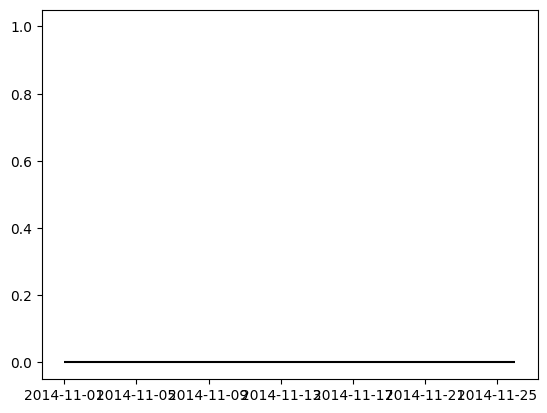

In [246]:
test = storms_that_caused_outages.sample(1)
test = test.reset_index().reset_index()

plt.hlines(test.level_0, test.begin_datetime, test.end_datetime, color='k')
plt.hlines(test.level_0 + 1, test.run_start_time_min, test.run_start_time_max, color='r')

In [251]:
storms_that_caused_outages

,EPISODE_ID,nb_events,affected_states,affected_states_ids,distinct_events,touched_cz_fips,touched_cz_names,timezone,episode_description,begin_datetime,end_datetime,duration,state,outage_index_id,fips_code,fips_code_id,county,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration,outage_start_minus_storm_start,outage_end_minus_storm_end,outage_start_minus_storm_end,outage_end_minus_storm_start,storm_caused_outage_cond1,storm_caused_outage_cond2,storm_caused_outage_cond3
276419,90052,11,[CALIFORNIA],[6],[Drought],"[89, 95, 96, 94, 98, 99, 97, 90, 91, 92, 93]","[W CENTRAL S.J. VALLEY, KERN CTY MTNS, S SIERR...",[PST-8],The California drought continued in full force...,2014-10-01 00:00:00,2014-10-31 23:59:00,743.983333,california,06037__0000,6037.0,06037,Los Angeles,CA,45.0,799120.0,2014-11-01 11:30:00,2014-11-01 22:45:00,0.468750,1.704789e+06,31.479167,0.948611,0.479861,31.947917,True,False,True
282337,90230,13,[PENNSYLVANIA],[42],[Strong Wind],"[60, 62, 61, 54, 55, 104, 70, 71, 103, 105, 10...","[BERKS, NORTHAMPTON, LEHIGH, CARBON, MONROE, E...",[EST-5],An intense low pressure that passed east of Ne...,2014-11-02 08:00:00,2014-11-02 15:00:00,7.000000,pennsylvania,42091__0000,42091.0,42091,Montgomery,PA,19.0,236678.0,2014-11-02 15:15:00,2014-11-02 20:00:00,0.197917,1.195847e+06,0.302083,0.208333,0.010417,0.500000,True,False,True
282730,90244,5,[SOUTH CAROLINA],[45],"[Winter Weather, Heavy Snow]","[25, 27, 20, 30, 26]","[EDGEFIELD, LEXINGTON, NEWBERRY, AIKEN, SALUDA]",[EST-5],A deep upper core low moved through the wester...,2014-11-01 05:30:00,2014-11-01 10:30:00,5.000000,south carolina,45045__0000,45045.0,45045,Greenville,SC,3.0,30449.0,2014-11-01 12:00:00,2014-11-01 15:15:00,0.135417,2.248542e+05,0.270833,0.197917,0.062500,0.406250,True,False,True
282847,90252,6,[NEW YORK],[36],[Strong Wind],"[176, 178, 71, 80, 78, 81]","[NORTHERN QUEENS, SOUTHERN QUEENS, SOUTHERN WE...",[EST-5],Deep low pressure passed south and east of Lon...,2014-11-02 02:00:00,2014-11-02 15:00:00,13.000000,new york,36119__0000,36119.0,36119,Westchester,NY,15.0,175314.0,2014-11-02 14:45:00,2014-11-02 18:30:00,0.156250,1.122010e+06,0.531250,0.145833,-0.010417,0.687500,True,True,False
283830,90288,9,[SOUTH CAROLINA],[45],[Winter Weather],"[2, 7, 12, 1, 11, 19, 10, 6, 3]","[PICKENS MOUNTAINS, SPARTANBURG, LAURENS, OCON...",[EST-5],Precipitation associated with a strong upper l...,2014-11-01 02:00:00,2014-11-01 06:00:00,4.000000,south carolina,45045__0000,45045.0,45045,Greenville,SC,3.0,30449.0,2014-11-01 12:00:00,2014-11-01 15:15:00,0.135417,2.248542e+05,0.416667,0.385417,0.250000,0.552083,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018575,113371,3,[CALIFORNIA],[6],"[Heavy Snow, High Wind]","[73, 70]","[MONO, SURPRISE VALLEY]",[PST-8],A strong system and an associated cold front b...,2016-12-14 23:00:00,2016-12-16 06:00:00,31.000000,california,06073__0018,6073.0,06073,San Diego,CA,7.0,70616.0,2016-12-16 09:30:00,2016-12-16 11:15:00,0.072917,9.684480e+05,1.437500,0.218750,0.145833,1.510417,True,False,True
1018734,113374,1,[CALIFORNIA],[6],[Heavy Snow],[73],[MONO],[PST-8],Low pressure moved from the Gulf of Alaska int...,2016-12-23 10:00:00,2016-12-24 00:00:00,14.000000,california,06067__0030,6067.0,06067,Sacramento,CA,4.0,51649.0,2016-12-23 11:15:00,2016-12-23 12:15:00,0.041667,1.239576e+06,0.052083,-0.489583,-0.531250,0.093750,True,True,False
1267712,121054,9,[ILLINOIS],[17],"[Hail, Thunderstorm Wind]","[91, 201, 75, 99, 105]","[KANKAKEE, WINNEBAGO, IROQUOIS, LA SALLE, LIVI...",[CST-6],A line of strong to severe thunderstorms moved...,2016-03-15 19:47:00,2016-03-15 22:42:00,2.916667,illinois,17031__0007,17031.0,17031,Cook,IL,6.0,68222.0,2016-03-16 20:00:00,2016-03-16 22:00:00,0.083333,8.186640e+05,1.009028,0.970833,0.887500,1.092361,True,False,True
1267728,121054,9,[ILLINOIS],[17

In [272]:
test = storms_that_caused_outages[storms_that_caused_outages.outage_index_id=='53063__0002']
test = test.loc[test.touched_cz_names.explode()[test.touched_cz_names.explode().str.contains(test.county.str.upper().unique()[0])].index]



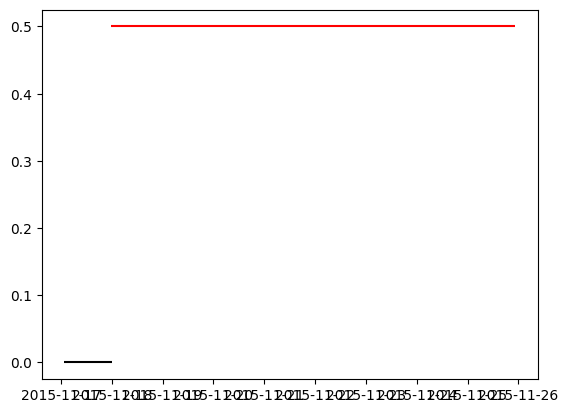

In [275]:
test2 = test.reset_index().reset_index()#storms_that_caused_outages[storms_that_caused_outages.outage_index_id=='53063__0002'].reset_index().reset_index()
plt.hlines(test2.level_0, test2.begin_datetime, test2.end_datetime, color='k')
plt.hlines(test2.level_0 + 0.5, test2.run_start_time_min, test2.run_start_time_max, color='r')

In [212]:
storms_outages[storms_outages.outage_index_id=='53063__0002']

,EPISODE_ID,nb_events,affected_states,affected_states_ids,distinct_events,touched_cz_fips,touched_cz_names,timezone,episode_description,begin_datetime,end_datetime,duration,state,fips_code_id,outage_index_id,fips_code,county,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration,outage_start_minus_storm_start,outage_end_minus_storm_end,outage_start_minus_storm_end,outage_end_minus_storm_start,storm_caused_outage_cond1,storm_caused_outage_cond2,storm_caused_outage_cond3
6178,81564,8,[WASHINGTON],53,"[High Wind, Flood, Heavy Snow, Strong Wind]",63,"[MOSES LAKE AREA, SPOKANE, NORTHEAST MOUNTAINS...",[PST-8],A deep fetch of Pacific moisture brought heavy...,2014-01-10 19:00:00,2014-01-12 06:00:00,35.000000,washington,53063,53063__0002,53063.0,Spokane,WA,747.0,42833797.0,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06,676.187500,682.687500,674.729167,684.145833,True,False,False
13966,82814,5,[WASHINGTON],53,[Flood],63,"[WHITMAN, SPOKANE, ADAMS, LINCOLN, STEVENS]",[PST-8],Numerous areas across the Idaho Panhandle deal...,2014-02-12 12:00:00,2014-02-14 12:00:00,48.000000,washington,53063,53063__0002,53063.0,Spokane,WA,747.0,42833797.0,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06,643.479167,649.437500,641.479167,651.437500,True,False,False
18779,83593,5,[WASHINGTON],53,[Thunderstorm Wind],63,"[WHITMAN, SPOKANE]",[PST-8],A vigorous occluded front pushed across the re...,2014-03-14 13:06:00,2014-03-14 13:13:00,0.116667,washington,53063,53063__0002,53063.0,Spokane,WA,747.0,42833797.0,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06,613.433333,621.386806,613.428472,621.391667,True,False,False
18818,83601,5,[WASHINGTON],53,"[Winter Weather, Debris Flow, Flood]",63,"[NORTHEAST MOUNTAINS, SPOKANE, LINCOLN, WHITMAN]",[PST-8],The region was under a transitioning weather r...,2014-03-05 03:30:00,2014-03-06 23:59:00,44.483333,washington,53063,53063__0002,53063.0,Spokane,WA,747.0,42833797.0,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06,622.833333,628.938194,620.979861,630.791667,True,False,False
38092,88194,1,[WASHINGTON],53,[Heavy Rain],63,[SPOKANE],[PST-8],A moist and unstable atmosphere over Eastern W...,2014-06-26 13:00:00,2014-06-26 13:40:00,0.666667,washington,53063,53063__0002,53063.0,Spokane,WA,747.0,42833797.0,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06,509.437500,517.368056,509.409722,517.395833,True,False,False
38097,88195,1,[WASHINGTON],53,[Thunderstorm Wind],63,[SPOKANE],[PST-8],Thunderstorms near the Spokane Stevens County ...,2014-05-05 13:55:00,2014-05-05 14:05:00,0.166667,washington,53063,53063__0002,53063.0,Spokane,WA,747.0,42833797.0,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06,561.399306,569.350694,561.392361,569.357639,True,False,False
38153,88211,3,[WASHINGTON],53,"[Thunderstorm Wind, Wildfire]",63,"[SPOKANE, OKANOGAN, SPOKANE AREA]",[PST-8],A closed upper-level low was positioned over E...,2014-07-14 14:00:00,2014-07-14 17:30:00,3.500000,washington,53063,53063__0002,53063.0,Spokane,WA,747.0,42833797.0,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06,491.395833,499.208333,491.250000,499.354167,True,False,False
38167,88213,15,[WASHINGTON],53,"[Thunderstorm Wind, Hail, Debris Flow]",63,"[PEND OREILLE, OKANOGAN, STEVENS, WHITMAN, SPO...",[PST-8],A deep trough of low pressure dropped down the...,2014-07-23 12:00:00,2014-07-23 17:00:00,5.000000,washington,53063,53063__0002,53063.0,Spokane,WA,747.0,42833797.0,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06,482.479167,490.229167,482.270833,490.437500,True,False,False
39840,88652,8,[WASHINGTON],53,[Thunderstorm Wind],63,"[PEND OREILLE, OKANOGAN, LINCOLN, FERRY, STEVE...",[PST-8],A strong upper-level ridge during the end of J...,2014-08-02 12:40:00,2014-08-02 17:15:00,4.583333,washington,53063,53063__0002,53063.0,Spokane,WA,747.0,42833797.0,2015-11-17 23:30:00,2015-11-25 22:30:00,7

In [215]:
outages_index_resumed[outages_index_resumed.outage_duration==outages_index_resumed.outage_duration.max()]


,outage_index_id,fips_code,fips_code_id,county,state,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration
1418,53063__0002,53063,53063,Spokane,washington,WA,747,42833797,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06


In [214]:
storm_episodes[
    (storm_episodes.state=='washington') & (storm_episodes.begin_datetime>=pd.to_datetime('2015-11-01'))
]


,EPISODE_ID,nb_events,affected_states,affected_states_ids,distinct_events,touched_cz_fips,touched_cz_names,timezone,episode_description,begin_datetime,end_datetime,duration,state
17729,100553,7,[WASHINGTON],[53],"[Strong Wind, High Wind]","[559, 511, 558, 517, 555, 507, 503]","[BREMERTON AND VICINITY, HOOD CANAL AREA, SEAT...",[PST-8],Windy conditions lasted for several hours over...,2015-11-17 09:00:00,2015-11-17 15:00:00,6.000000,washington
17731,100555,29,[WASHINGTON],[53],"[High Wind, Dust Storm]","[36, 37, 34, 42, 35, 33, 38]","[SPOKANE AREA, NORTHEAST MOUNTAINS, MOSES LAKE...",[PST-8],An intense surface low pressure system moved f...,2015-11-17 01:36:00,2015-11-17 23:59:00,22.383333,washington
17857,100692,5,[WASHINGTON],[53],"[Flood, Heavy Rain]","[31, 33, 61, 9, 41]","[JEFFERSON, KING, SNOHOMISH, CLALLAM, LEWIS]",[PST-8],The Elwha River flexed its new muscles during ...,2015-11-14 00:00:00,2015-11-18 15:00:00,111.000000,washington
17907,100750,2,[WASHINGTON],[53],[Heavy Snow],[38],[OKANOGAN HIGHLANDS],[PST-8],A weather system dropped heavy localized snow ...,2015-11-23 20:00:00,2015-11-24 08:00:00,12.000000,washington
18006,100856,6,[WASHINGTON],[53],[High Wind],"[27, 520, 521, 29, 30, 28]","[YAKIMA VALLEY, EAST SLOPES OF THE WASHINGTON ...",[PST-8],A strong pacific system moved through the paci...,2015-11-17 10:00:00,2015-11-18 04:35:00,18.583333,washington
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106779,196736,1,[WASHINGTON],[53],[Wildfire],[37],[NORTHEAST MOUNTAINS],[PST-8],Upper Ruby Wildfire was started on August 20 b...,2024-09-01 00:00:00,2024-09-03 16:00:00,64.000000,washington
106780,196737,1,[WASHINGTON],[53],[Wildfire],[38],[OKANOGAN HIGHLANDS],[PST-8],The Goosmus Fire was started on September 25. ...,2024-09-25 13:48:00,2024-09-30 23:59:00,130.183333,washington
106782,196739,1,[WASHINGTON],[53],[Funnel Cloud],[11],[CLARK],[PST-8],A strong shower produced a funnel cloud near L...,2024-09-25 17:45:00,2024-09-25 17:46:00,0.016667,washington
106803,196772,1,[WASHINGTON],[53],[Wildfire],[47],[CENTRAL CHELAN COUNTY],[PST-8],The Pioneer Fire started on June 8 by unknown ...,2024-09-01 00:00:00,2024-09-30 23:59:00,719.983333,washington


In [220]:
outages_index_resumed[outages_index_resumed.fips_code_id=='53063']

,outage_index_id,fips_code,fips_code_id,county,state,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration
1416,53063__0000,53063,53063,Spokane,washington,WA,4,54009,2015-08-30 23:45:00,2015-08-31 00:45:00,0.041667,1.296216e+06
1417,53063__0001,53063,53063,Spokane,washington,WA,5,80379,2015-09-30 11:00:00,2015-09-30 13:15:00,0.093750,8.573760e+05
1418,53063__0002,53063,53063,Spokane,washington,WA,747,42833797,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06
1419,53063__0003,53063,53063,Spokane,washington,WA,6,74064,2015-12-29 00:30:00,2015-12-29 02:00:00,0.062500,1.185024e+06
1420,53063__0004,53063,53063,Spokane,washington,WA,6,74284,2016-08-08 00:15:00,2016-08-08 01:45:00,0.062500,1.188544e+06


In [217]:
storm_events[storm_events.CZ_NAME =='SPOKANE AREA']

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,BEGIN_DATETIME,END_DATETIME,DURATION_HOURS
1961,201403,2,1150,201403,2,2330,83590,504732,WASHINGTON,53,2014,March,Heavy Snow,Z,36,SPOKANE AREA,OTX,02-MAR-14 11:50:00,PST-8,02-MAR-14 23:30:00,0,0,0,0,0.00K,0.00K,COOP Observer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The region was under a cold and dry air mass a...,NaN,CSV,2014-03-02 11:50:00,2014-03-02 23:30:00,11.666667
3328,201403,1,0,201403,1,500,83597,504767,WASHINGTON,53,2014,March,Strong Wind,Z,36,SPOKANE AREA,OTX,01-MAR-14 00:00:00,PST-8,01-MAR-14 05:00:00,0,0,0,0,5.00K,0.00K,Newspaper,38.0,MG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An Arctic front pushed into eastern Washington...,Power lines knocked down by toppled trees. An...,CSV,2014-03-01 00:00:00,2014-03-01 05:00:00,5.000000
8208,201407,19,1700,201407,23,1330,89055,536680,WASHINGTON,53,2014,July,Wildfire,Z,36,SPOKANE AREA,OTX,19-JUL-14 17:00:00,PST-8,23-JUL-14 13:30:00,0,0,0,0,2.00K,0.00K,Broadcast Media,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The Watermelon Hill fire started in Lincoln Co...,The Watermelon Hill fire was wind fanned and q...,CSV,2014-07-19 17:00:00,2014-07-23 13:30:00,92.500000
8822,201407,14,1400,201407,14,1600,88211,536718,WASHINGTON,53,2014,July,Wildfire,Z,36,SPOKANE AREA,OTX,14-JUL-14 14:00:00,PST-8,14-JUL-14 16:00:00,0,0,0,0,4.00K,0.00K,Broadcast Media,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A closed upper-level low was positioned over E...,A brush fire on Old Miner Road off Mount Spoka...,CSV,2014-07-14 14:00:00,2014-07-14 16:00:00,2.000000
14959,201402,13,1100,201402,13,1200,82812,500839,WASHINGTON,53,2014,February,Strong Wind,Z,36,SPOKANE AREA,OTX,13-FEB-14 11:00:00,PST-8,13-FEB-14 12:00:00,0,0,0,0,1.00K,0.00K,Broadcast Media,39.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Conditions on the 12th of February were genera...,A large tree branch snapped off a tree and lan...,CSV,2014-02-13 11:00:00,2014-02-13 12:00:00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603070,202308,18,1600,202308,31,2359,184916,1138825,WASHINGTON,53,2023,August,Wildfire,Z,36,SPOKANE AREA,OTX,18-AUG-23 16:00:00,PST-8,31-AUG-23 23:59:00,0,0,1,0,15.00M,0.00K,Emergency Manager,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An incoming system brought strong winds and dr...,The fire started by unknown human causes 4 mil...,CSV,2023-08-18 16:00:00,2023-08-31 23:59:00,319.983333
615401,202307,31,1354,202307,31,2359,184228,1127067,WASHINGTON,53,2023,July,Wildfire,Z,36,SPOKANE AREA,OTX,31-JUL-23 13:54:00,PST-8,31-JUL-23 23:59:00,0,0,0,0,1.70M,0.00K,Fire Department/Rescue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West Hallett Fire started on July 31 from unkn...,West Hallett started on July 31 from unknown c...,CSV,2023-07-31 13:54:00,2023-07-31 23:59:00,10.083333
633051,202402,25,1053,202402,26,220,189268,1164003,WASHINGTON,53,2024,February,Strong Wind,Z,36,SPOKANE AREA,OTX,25-FEB-24 10:53:00,PST-8,26-FEB-24 02:20:00,0,0,0,0,2.00K,0.00K,Utility Company,42.0,MG,NaN,NaN,Na

## References

In [317]:
otg = outages.drop_duplicates('fips_code_id')[['county', 'fips_code_id','state_id', 'state']]

In [313]:
se = storm_events[['STATE', 'STATE_FIPS', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME']]
se['fips_code_id'] = (se.STATE_FIPS.astype(str).str.zfill(2) + se.CZ_FIPS.astype(str).str.zfill(3))
se.drop_duplicates('fips_code_id', inplace=True)

/tmp/ipykernel_28197/3749549476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se['fips_code_id'] = (se.STATE_FIPS.astype(str).str.zfill(2) + se.CZ_FIPS.astype(str).str.zfill(3))
/tmp/ipykernel_28197/3749549476.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se.drop_duplicates('fips_code_id', inplace=True)


In [330]:
import geopandas as gpd
datapath = '../data/external/cb_2018_us_county_5m/cb_2018_us_county_5m.shp'
county = gpd.read_file(datapath)

In [368]:
STATE_ID = "01"
county_state = county[county.STATEFP==STATE_ID]
id_to_name_dict = county_state.set_index("GEOID")['NAME'].to_dict()
name_to_id_dict = county_state.set_index("NAME")['GEOID'].to_dict()

storm_events_state = se[se.STATE_FIPS.astype(str).str.zfill(2) == STATE_ID].sort_values('CZ_NAME')

In [386]:
for name, fips_id in name_to_id_dict.items():
    name_condition1 = storm_events_state.CZ_NAME.str.lower().str.contains(name.lower())
    name_condition2 = storm_events_state.CZ_NAME.str.lower().apply(lambda x: word_similarity(x, name)) > WORD_SIMILARITY_THRESHOLD
    storm_events_state.loc[((name_condition1)|(name_condition2)), 'new_id'] = fips_id

In [380]:
def word_similarity(w1, w2):
    similarity = SequenceMatcher(None, w1, w2).ratio()
    return similarity

In [392]:
county_state.sort_values('NAME')

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
3043,01,001,00161526,0500000US01001,01001,Autauga,06,1539602123,25706961,"POLYGON ((-86.91759 32.66417, -86.81657 32.660..."
40,01,003,00161527,0500000US01003,01003,Baldwin,06,4117546676,1133055836,"POLYGON ((-88.02927 30.22271, -88.02399 30.230..."
3044,01,005,00161528,0500000US01005,01005,Barbour,06,2292144655,50538698,"POLYGON ((-85.74142 31.61961, -85.72983 31.632..."
2822,01,007,00161529,0500000US01007,01007,Bibb,06,1612167481,9602089,"POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
774,01,009,00161530,0500000US01009,01009,Blount,06,1670103911,15015423,"POLYGON ((-86.96336 33.85822, -86.9202 33.8734..."
1822,01,011,00161531,0500000US01011,01011,Bullock,06,1613059160,6054988,"POLYGON ((-85.99916 32.25054, -85.98655 32.250..."
696,01,013,00161532,0500000US01013,01013,Butler,06,2012002530,2701198,"POLYGON ((-86.90894 31.96167, -86.85758 31.962..."
3035,01,015,00161533,0500000US01015,01015,Calhoun,06,1569189622,16627597,"POLYGON ((-86.14371 33.70913, -86.12388 33.710..."
2589,01,017,00161534,0500000US01017,01017,Chambers,06,1545085607,16971701,"POLYGON ((-85.59318 33.10734, -85.23244 33.108..."
3098,01,019,00161535,0500000US01019,01019,Cherokee,06,1433623321,120308339,"POLYGON ((-85.84384 34.24345, -85.82548 34.240..."


In [387]:
storm_events_state

,STATE,STATE_FIPS,CZ_TYPE,CZ_FIPS,CZ_NAME,fips_code_id,new_id
16070,ALABAMA,1,Z,41,AUTAUGA,01041,01001
192062,ALABAMA,1,Z,264,BALDWIN CENTRAL,01264,01003
192060,ALABAMA,1,Z,266,BALDWIN COASTAL,01266,01003
192066,ALABAMA,1,Z,262,BALDWIN INLAND,01262,01003
16352,ALABAMA,1,Z,50,BARBOUR,01050,01005
2577,ALABAMA,1,Z,34,BIBB,01034,01007
952,ALABAMA,1,Z,17,BLOUNT,01017,01009
15168,ALABAMA,1,Z,46,BULLOCK,01046,01011
1492,ALABAMA,1,C,15,CALHOUN,01015,01015
1416,ALABAMA,1,Z,19,CALHOUN,01019,01015


In [389]:
se[se.STATE_FIPS.astype(str).str.zfill(2) == STATE_ID].sort_values('CZ_NAME')

,STATE,STATE_FIPS,CZ_TYPE,CZ_FIPS,CZ_NAME,fips_code_id
16070,ALABAMA,1,Z,41,AUTAUGA,01041
192062,ALABAMA,1,Z,264,BALDWIN CENTRAL,01264
192060,ALABAMA,1,Z,266,BALDWIN COASTAL,01266
192066,ALABAMA,1,Z,262,BALDWIN INLAND,01262
16352,ALABAMA,1,Z,50,BARBOUR,01050
2577,ALABAMA,1,Z,34,BIBB,01034
952,ALABAMA,1,Z,17,BLOUNT,01017
15168,ALABAMA,1,Z,46,BULLOCK,01046
1492,ALABAMA,1,C,15,CALHOUN,01015
1416,ALABAMA,1,Z,19,CALHOUN,01019


In [349]:
from difflib import SequenceMatcher

In [367]:
s = se[~se.fips_code_id.isin(otg.fips_code_id)]
s[s.STATE_FIPS==1].sort_values(['STATE_FIPS','CZ_NAME'])

,STATE,STATE_FIPS,CZ_TYPE,CZ_FIPS,CZ_NAME,fips_code_id
192062,ALABAMA,1,Z,264,BALDWIN CENTRAL,01264
192060,ALABAMA,1,Z,266,BALDWIN COASTAL,01266
192066,ALABAMA,1,Z,262,BALDWIN INLAND,01262
16352,ALABAMA,1,Z,50,BARBOUR,01050
2577,ALABAMA,1,Z,34,BIBB,01034
952,ALABAMA,1,Z,17,BLOUNT,01017
15168,ALABAMA,1,Z,46,BULLOCK,01046
1416,ALABAMA,1,Z,19,CALHOUN,01019
1492,ALABAMA,1,C,15,CALHOUN,01015
15461,ALABAMA,1,Z,38,CHAMBERS,01038


In [390]:
#otg[otg.state=='Alabama'].sort_values('county')

In [294]:
#outages_fips = outages.fips_code.astype(str).str.zfill(5).unique()#outages_index_resumed.fips_code_id.unique()

In [286]:
storm_fips = (storm_events.STATE_FIPS.astype(str).str.zfill(2) + storm_events.CZ_FIPS.astype(str).str.zfill(3)).unique()

In [296]:
len(set(storm_fips)-set(outages_fips))

3558

In [297]:
len(set(outages_fips)-set(storm_fips))

6